# Lesson8.4 CART回归树的建模流程与sklearn参数详解

接下来，我们继续讨论关于CART回归树的相关内容。

根据此前介绍，CART树能同时解决分类问题和回归问题，但由于两类问题的性质还是存在一定的差异，因此CART树在处理不同类型问题时相应建模流程也略有不同，当然对应的skearn中的评估器也是不同的。并且值得一提的是，尽管回归树单独来看是解决回归类问题的模型，但实际上回归树其实是构建梯度提升树(GBDT,一种集成算法)的基础分类器，并且无论是解决回归类问题还是分类问题，CART回归树都是唯一的基础分类器，因此那怕单独利用回归树解决问题的场景并不多见，但对于CART回归树的相关方法仍然需要重点掌握，从而为后续集成算法的学习奠定基础。

本节我们将在CART分类树的基础之上详细讨论CART树在处理回归问题时的基本流程，并详细介绍关于CART回归树在sklearn中评估器的的相关参数与使用方法。

In [1]:
# 科学计算模块
import numpy as np
import pandas as pd

# 画图模块
import matplotlib.pyplot as plt

# 机器学习模块
from ML_basic_function import *

# Scikit-Learn
# 评估模器模块
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import  LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import  GridSearchCV

# 实用函数
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 数据准备
from sklearn.datasets import load_iris


## 一、CART回归树的基本建模流程

同样，我们先从一个极简的例子来了解CART回归树的基本建模流程，然后再介绍通过数学语言描述得更加严谨的建模流程。

* 数据准备
  
首先我们创建一个简单的回归数据集如下，该数据集只包含一个特征和一个连续型标签：

![alt text](image-136.png)

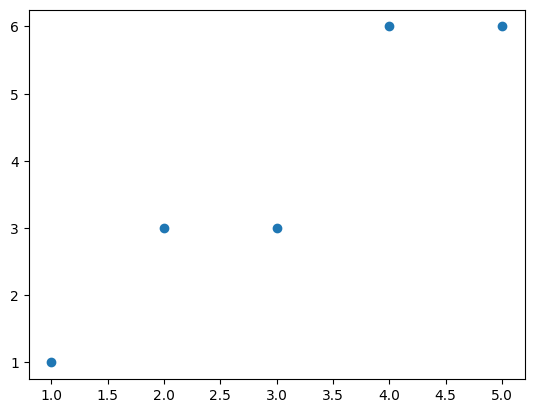

In [2]:
data = np.array([[1, 1], [2, 3], [3, 3], [4, 6], [5, 6]])
plt.scatter(data[:,0],data[:,1])

其中横坐标代表数据集特征，纵坐标代表数据集标签。

* 生成备选规则

CART回归树和分类树流程类似，从具体操作步骤来看，首先都是寻找切分点对数据集进行切分，或者说需要确定备
选划分规则。回归树中寻找切分点的方式和分类树的方式相同，都是逐特征寻找不同取值的中间点作为切分点。对于上述数据集来说，由于只有一个特征，并且总共有5个不同的取值，因此切分点有4个。而根据此前介绍，有几个切分点就有几种数据集划分方式、即有同等数量的备选划分规则、或有同等数量的树的生长方式。初始数据集的4个不同的划分方式，可以通过如下方式进行呈现：

In [3]:
y_range = np.arange(1, 6, 0.1)

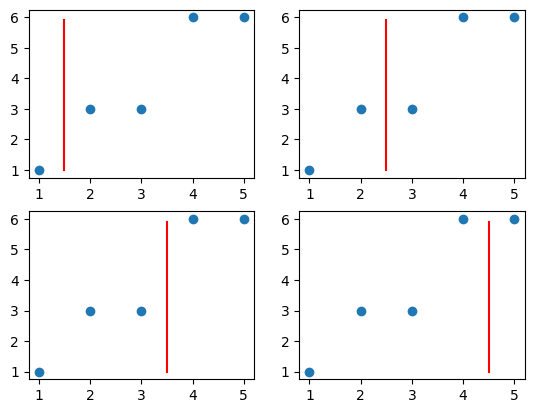

In [4]:
plt.subplot(2, 2, 1)
plt.scatter(data[:,0],data[:,1])
plt.plot(np.full_like(y_range, 1.5), y_range, color='r')
plt.subplot(2, 2, 2)
plt.scatter(data[:,0],data[:,1])
plt.plot(np.full_like(y_range, 2.5), y_range, color='r')
plt.subplot(2, 2, 3)
plt.scatter(data[:,0],data[:,1])
plt.plot(np.full_like(y_range, 3.5), y_range, color='r')
plt.subplot(2, 2, 4)
plt.scatter(data[:,0],data[:,1])
plt.plot(np.full_like(y_range, 4.5), y_range, color='r')
plt.show()

* 挑选规则
  
在确定了备选划分规则之后，接下来需要根据某种评估标准来寻找最佳划分方式。回归树的该步骤和分类树差异较大，分类树中我们是采用基尼系数或者信息熵来衡量划分后数据集标签不纯度下降情况来挑选最佳划分方式，而在回归树中，则是根据划分之后子数据集MSE下降情况来进行最佳划分方式的挑选。在该过程中，子数据集整体的MSE计算方法也和CART分类树类似，都是先计算每个子集单独的MSE,然后再通过加权求和的方法来进行计算两个子集整体的MSE。

此处MSE的计算虽然不复杂，但我们知道，但凡需要计算MSE,就必须给出一个预测值，然后我们才能根据预测值和真实值计算MSE。而CART回归树在进行子数据集的划分之后，会针对每个子数据集给出一个预测值（注意是针对一个子数据集中所有数据给出一个预测值，而不是针对每一个数给出一个预测值），而该预测值会依照让对应子数据集MSE最小的目标进行计算得出。

让MSE取值最小这一目标其实等价于让SSE取值最小，而用一个数对一组数进行预测并且要求SSE最小，其实就相当于K-Means快速聚类过程中所要求的寻找组内误差平方和最小的点作为中心点，我们曾在Lesson7中进行过相关数学推导，此时选取这组数的质心能够让组内误差平方和计算结果最小。而此时情况也是类似，只不过我们针对一组一维的数据去寻找一个能够使得组内误差平方和的最小的点，这个点仍然是这组数据的质心，而一维数据的质心，其实就是这组数据的均值。那么也就是说，在围绕让每一个子数据集MSE取值最小这一目标下，每个子数据集的最佳预测值就是这个子数据集真实标签的均值。

具体计算过程如下，例如对上述第一种划分数据集的情况来说，每个子数据集的预测值和MSE计算结果如下：

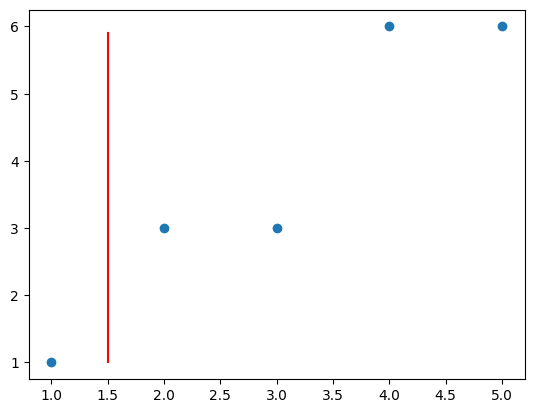

In [5]:
plt.scatter(data[:,0],data[:,1])
plt.plot(np.full_like(y_range, 1.5), y_range, color='r')

对应划分情况也可以通过如下形式进行表示：

![alt text](image-137.png)

此时可计算子数据集B1和B2的MSE,首先是两个数据集的预测值，也就是两个数据集的均值：

In [6]:
data[0, 1]

1

In [8]:
# B1数据集的预测值
y_1 = np.mean(data[0, 1])
y_1

1.0

In [9]:
data[1:, 1]

array([3, 3, 6, 6])

In [10]:
# B2数据集的预测值
y_2 = np.mean(data[1:, 1])
y_2

4.5

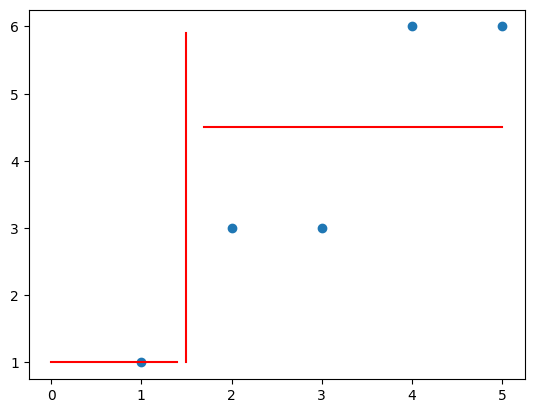

In [15]:
# 模型预测结果
plt.scatter(data[:,0],data[:,1])
plt.plot(np.full_like(y_range, 1.5), y_range, color='r')
plt.plot(np.arange(0, 1.5, 0.1), np.full_like(np.arange(0, 1.5, 0.1), y_1), color='r')
plt.plot(np.arange(1.7, 5.1, 0.1), np.full_like(np.arange(1.7, 5.1, 0.1), y_2), color='r')

然后计算两个子集的MSE:

In [16]:
# B1的MSE
mse_b1 = 0

In [17]:
# B2的MSE
mse_b2 = np.power(data[1:, 1] - y_2, 2).sum() / 4
mse_b2

2.25

然后和CART分类树一样，以各子集所占全集的样本比例为权重，通过加权求和的方式计算两个子集整体的MSE:

In [18]:
mse_b = 1/5 * mse_b1 + 4/5 * mse_b2
mse_b

1.8

而父节点的MSE为：

In [19]:
data[:, 1].mean()

3.8

In [20]:
mse_a = np.power(data[:, 1] - data[:, 1].mean(), 2).sum() / 5
mse_a

3.7599999999999993

因此，本次划分所降低的MSE为：

即为该种划分方式的最终评分。当然，我们要以相似的流程计算其他几种划分方式的评分，然后从中挑选能够最大程度降低MSE的划分方式，基本流程如下：

In [22]:
impurity_decrease = []

for i in range(4):
    # 寻找最佳切分点
    setting_point = data[i: i+2, 0].mean()

    # 进行切分
    data_b1 = data[data[:, 0] <= setting_point]
    data_b2 = data[data[:, 0] > setting_point]

    # 计算两个字集的MSE
    mse_b1 = np.power(data_b1[:, 1] - data_b1[:, 1].mean(), 2).sum() / data_b1.shape[0]
    mse_b2 = np.power(data_b2[:, 1] - data_b2[:, 1].mean(), 2).sum() / data_b2.shape[0]

    # 计算两个子集的MSE加权和
    mse_b = data_b1.shape[0] / data.shape[0] * mse_b1 + data_b2.shape[0] / data.shape[0] * mse_b2

    # 计算不纯度的减少
    impurity_decrease.append(mse_a - mse_b)

In [23]:
impurity_decrease

[1.9599999999999993, 2.1599999999999993, 3.226666666666666, 1.209999999999999]

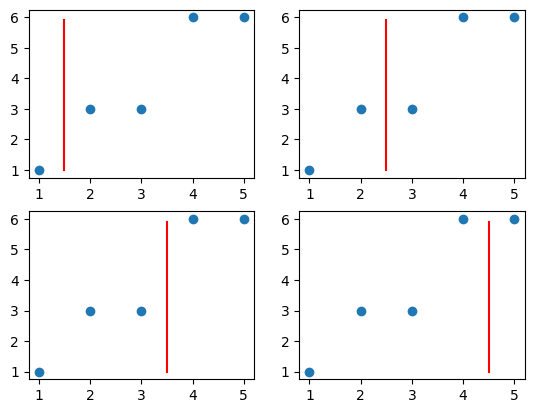

In [24]:
plt.subplot(2, 2, 1)
plt.scatter(data[:,0],data[:,1])
plt.plot(np.full_like(y_range, 1.5), y_range, color='r')
plt.subplot(2, 2, 2)
plt.scatter(data[:,0],data[:,1])
plt.plot(np.full_like(y_range, 2.5), y_range, color='r')
plt.subplot(2, 2, 3)
plt.scatter(data[:,0],data[:,1])
plt.plot(np.full_like(y_range, 3.5), y_range, color='r')
plt.subplot(2, 2, 4)
plt.scatter(data[:,0],data[:,1])
plt.plot(np.full_like(y_range, 4.5), y_range, color='r')
plt.show()

根据最终结果能够看出，第三种划分情况能够最大程度降低MSE,即此时树模型的第一次生长情况如下：

![alt text](image-138.png)

* 进行多轮迭代
  
当然，和CART分类树一样，接下来，我们就能够进一步围绕B1和B2进行进一步划分。此时B2的MSE已经为0，因此无需再进行划分，而B1的MSE为0.88，还可以进一步进行划分。当然B1的划分过程也和A数据集的划分过程一致，寻找能够令子集MSE下降最多的方式进行切分。不过由于B1数据集本身较为简单，通过观察不难发现，我们可以以x<=1,5作为划分条件对其进行切分，进一步切分出来的子集的MSE都将取值为0。

![alt text](image-139.png)

此外，我们也可以观察当回归树生长了两层之后，相关规则对原始数据集的划分情况：

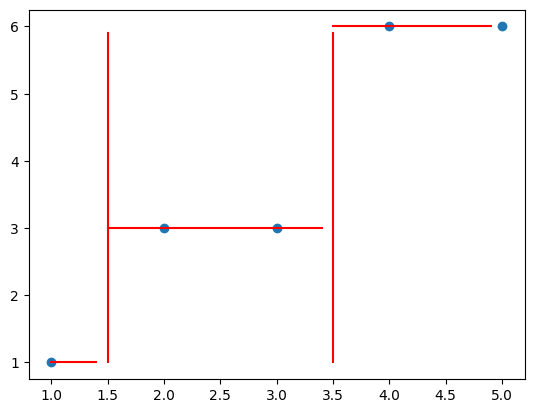

In [25]:
# 数据分布
plt.scatter(data[:,0],data[:,1])

# 两次划分
plt.plot(np.full_like(y_range, 1.5), y_range, color='r')
plt.plot(np.full_like(y_range, 3.5), y_range, color='r')

# 预测结果
plt.plot(np.arange(1, 1.5, 0.1), np.full_like(np.arange(1, 1.5, 0.1), 1), color='r')
plt.plot(np.arange(1.5, 3.5, 0.1), np.full_like(np.arange(1.5, 3.5, 0.1), 3), color='r')
plt.plot(np.arange(3.5, 5, 0.1), np.full_like(np.arange(3.5, 5, 0.1), 6), color='r')

不难发现，回归树的对标签的预测，实际上是一种“分区定值"的预测，建模过程的实际表现是对样本进行划分、然后每个区间给定一个预测值，并且树的深度越深、对样本空间的划分次数就越多、样本空间就会被分割成更多的子空间。在sklearn的说明文档中也有相关例子：

![alt text](image-140.png)

* 回归树的预测过程

而一旦当模型已经构建完成后，回归树的预测过程其实和分类树非常类似，新数据只要根据划分规则分配到所属样本空间，则该空间模型的预测结果就是该数据的预测结果。

至此，我们就在一个极简的数据集上完成了CART回归树的构建。不难发现，回归树和分类树的构建过程大致相同、迭代过程也基本一致，我们可以将其视作同一种建模思想的两种不同实现形式。

## 二、CART回归树的Scikit--Learn实现方法

### 1.CART回归树的sklearn快速实现

接下来，我们尝试在skearn中调用回归树评估器围绕上述数据集进行建模，并对上述过程进行简单验证。回归树也是在tree模块下，我们可以通过如下方式进行导入：

In [26]:
from sklearn.tree import DecisionTreeRegressor

然后进行模型训练：

In [27]:
clf = DecisionTreeRegressor().fit(data[:, 0].reshape(-1, 1), data[:, 1])

[Text(0.6, 0.8333333333333334, 'x[0] <= 3.5\nsquared_error = 3.76\nsamples = 5\nvalue = 3.8'),
 Text(0.4, 0.5, 'x[0] <= 1.5\nsquared_error = 0.889\nsamples = 3\nvalue = 2.333'),
 Text(0.2, 0.16666666666666666, 'squared_error = 0.0\nsamples = 1\nvalue = 1.0'),
 Text(0.6, 0.16666666666666666, 'squared_error = 0.0\nsamples = 2\nvalue = 3.0'),
 Text(0.8, 0.5, 'squared_error = 0.0\nsamples = 2\nvalue = 6.0')]

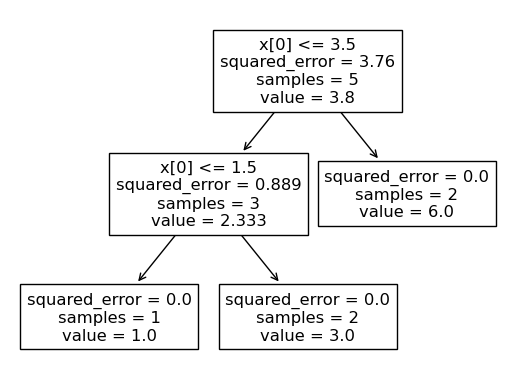

In [28]:
#同样可以用tree.plot_tree(clf)来可视化决策树
from sklearn import tree
tree.plot_tree(clf)

发现和我们手动实现过程一致。

### 2.CART回归树评估器的参数解释

接下来，详细讨论关于CART回归树评估器中的相关参数。尽管CART回归树和分类树是由不同评估器实现相关过程，但由于两种模型基本理论一致，因此两种不同评估器的参数也大都一致。

In [29]:
DecisionTreeRegressor?

Init signature:
DecisionTreeRegressor(
    *,
    criterion='squared_error',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    ccp_alpha=0.0,
    monotonic_cst=None,
)
Docstring:     
A decision tree regressor.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : {"squared_error", "friedman_mse", "absolute_error",             "poisson"}, default="squared_error"
    The function to measure the quality of a split. Supported criteria
    are "squared_error" for the mean squared error, which is equal to
    variance reduction as feature selection criterion and minimizes the L2
    loss using the mean of each terminal node, "friedman_mse", which uses
    mean squared error with Friedman's improvement score for potential
    splits, "absolute_error" for the mean absolute error, which minim

不难发现，其中大多数参数我们在Lesson8.2中都进行了详细的讲解，此处重点讲解criterion参数取值。criterion是备
选划分规则的选取指标，对于CART分类树来说默认基尼系数、可选信息嫡，而对于CART回归树来说默认mse,同时可选mae和friedman_mse,同时在新版sklearn中，还加入了poisson作为可选参数取值。接下来我们就这几个参数不同取值进行介绍：

* criterion='mse'情况
  
当criterion取值为mse时当然是计算误差平方和再除以样本总数，其基本计算流程与上述手动实现过程层类似。但有一点可能会对阅读源码的同学造成困扰，那就是在源码中子节点整体的MSE计算公式描述如下：

![alt text](image-141.png)

尽管上述公式看起来像是子节点的整体MSE就等于左右两个节点的方差只和，但实际上是经过加权之后的方差只和。我们可以通过在手动实现过程中灵活调整min_impurity_.decrease参数来进行验证。

> 需要注意的是，CART回归树的子节点整体MSE的计算方式是加权求和还是简单求和，不同的材料中有不同的描述，例如由Aurelien Geron等人所著《机器学习实战，基于Scikit-Learn、Keras和TensorFlow》一书中表示是通过加权求和方式算得，而在《统计学习方法》一书中则表示是根据子节点的MSE直接求和得到。

* criterion:='mae'情况
  
和MSE不同，MAE实际上计算的是预测值和真实值的差值的绝对值再除以样本总数，即可以通过如下公式计算得出：

$$
M A E=\frac{1}{m} \sum_{i=1}^m\left|\left(y_i-\hat{y}_i\right)\right|
$$

也就是说，MSE是基于预测值和真实值之间的欧式距离进行的计算，而MAE则是基于二者的街道距离进行的计算，很多时候，MSE也被称为L2损失，而MAE则被称为L1损失。

需要注意的是，当criterionl取值为mae时，为了让每一次划分时子集内的MAE值最小，此时每个子集的模型预测值就不再是均值，而是中位数。此时中位数的选取其实和Lesson7中介绍的K-Meas快速聚类的质心选取过程类似，当距离衡量方法改为街道距离时，能够让组内误差平方和最小的质心其实就是这一组数的中位数。

> 再次强调，CART回归树的criterion不仅是划分方式挑选时的评估标准，同时也是划分子数据集后选取预测值的决定因素。也就是说，对于回归树来说，criterion的取值其实决定了两个方面，其一是决定了损失值的计算方式、其二是决定了每一个子集的预测值的计算方式。

并且一般来说，如果希望模型对极端值(非常大或者非常小的值，也被称为离群值)的忍耐程度比较高，整体建模过程不受极端值影响，可以考虑使用mae参数（就类似于中位数会更少的受到极端值的影响），此时模型一般不会为极端值单独设置规则。而如果希望模型具备较好的识别极端值的能力，则可以考虑使用mse参数，此时模型会更大程度受到极端值影响（就类似于均值更容易受到极端值影响），更大概率会围绕极端值单独设置规则，从而帮助建模者对极端值进行识别。

> 为什么需要用模型来识别离群点？主要是因为对于高维空间中的样本点，我们很难通过简单的大小比较将离群点挑选出来。

* criterion:='friedman_mse'情况
  
friedman_mse是一种基于mse的改进型指标，是由GBDT(梯度提升树，一种集成算法)的提出者friedman.所设计的一种残差计算方法，是sklearn中树梯度提树默认的criterionl取值，对于单独的树决策树模型一般不推荐使用，关于friedman_mse的计算方法我们将在集成算法中进行详细介绍。